In [1]:
# coding: utf-8
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras import metrics



Using TensorFlow backend.


In [16]:
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
#!. ./env.sh
from keras import backend as K
#print(K.tensorflow_backend._get_available_gpus())


In [17]:
# 株価をロードする
def get_df_data():
    # 最初のカラム(年月日)をindexとし、最初の5行を読み飛ばす
    df = pd.read_csv('softbank_10years.csv', header=0)

    return df



In [18]:
df = get_df_data()
df.head()

,日付け,終値,始値,高値,安値,出来高,前日比%
0,2020年04月06日,"4,016.0","3,720.0","4,050.0","3,676.0",34.56M,7.61%
1,2020年04月03日,"3,732.0","3,797.0","3,877.0","3,702.0",27.96M,-0.96%
2,2020年04月02日,"3,768.0","3,629.0","3,840.0","3,596.0",45.24M,2.53%
3,2020年04月01日,"3,675.0","3,788.0","3,887.0","3,620.0",45.51M,-2.98%
4,2020年03月31日,"3,788.0","3,738.0","3,855.0","3,632.0",31.38M,2.57%


In [19]:
df = df.replace(['年', '月', '日', 'M', '%', ','], ['-', '-', '', '', '', ''], regex=True)
df.columns = ['date', 'end', 'begin', 'high', 'low', 'volume', 'ratio']

In [20]:
df.head()

,date,end,begin,high,low,volume,ratio
0,2020-04-06,4016.0,3720.0,4050.0,3676.0,34.56,7.61
1,2020-04-03,3732.0,3797.0,3877.0,3702.0,27.96,-0.96
2,2020-04-02,3768.0,3629.0,3840.0,3596.0,45.24,2.53
3,2020-04-01,3675.0,3788.0,3887.0,3620.0,45.51,-2.98
4,2020-03-31,3788.0,3738.0,3855.0,3632.0,31.38,2.57


In [21]:
# enforce yyyy-mm-dd
df.date = df.date.apply(
    lambda x: '{:04d}-{:02d}-{:02d}'.format(
        *[int(y) for y in x.split('-')]
        )
)
df.head()

,date,end,begin,high,low,volume,ratio
0,2020-04-06,4016.0,3720.0,4050.0,3676.0,34.56,7.61
1,2020-04-03,3732.0,3797.0,3877.0,3702.0,27.96,-0.96
2,2020-04-02,3768.0,3629.0,3840.0,3596.0,45.24,2.53
3,2020-04-01,3675.0,3788.0,3887.0,3620.0,45.51,-2.98
4,2020-03-31,3788.0,3738.0,3855.0,3632.0,31.38,2.57


In [22]:
df = df.set_index('date')
df = df.sort_index(ascending=True)
#df = df.reset_index(drop=True)
# df = df.drop(['index'], axis=1)
df.head()

,end,begin,high,low,volume,ratio
date,,,,,,
2010-03-08,2325.0,2335.0,2348.0,2311.0,5.94,-0.04
2010-03-09,2278.0,2320.0,2320.0,2278.0,5.20,-2.02
2010-03-10,2242.0,2276.0,2282.0,2242.0,5.82,-1.58
2010-03-11,2266.0,2260.0,2270.0,2244.0,5.38,1.07
2010-03-12,2280.0,2300.0,2303.0,2258.0,14.01,0.62


In [23]:
df[df.volume=='-']

,end,begin,high,low,volume,ratio
date,,,,,,
2015-09-20,6397.0,6397.0,6397.0,6397.0,-,2.03


In [24]:

# 扱う特徴量
FEATURE_VALUE = ['end', 'begin', 'high', 'low', 'volume', 'ratio']
# 次元数
DIMENSION = len(FEATURE_VALUE)

# df = get_df_data()
# 学習用データを取得(日付順にソート)
df = df.ix[:, FEATURE_VALUE]
#df = df.sort_index(ascending=False)
df = df.dropna() # 欠損値のある行を取り除く
df.volume[df.volume=='-']=0.0
df = df.astype(float)

# モデルに読み込ませるデータを生成する
def generate_data(data, length_per_unit, dimension):
    # DataFrame→array変換
    data_array = data.as_matrix()
    # 時系列データを入れる箱
    sequences = []
    # 正解データを入れる箱
    target = []
    # 正解データの日付を入れる箱
    target_date = []

    # 一グループごとに時系列データと正解データをセットしていく
    for i in range(0, data_array.shape[0] - length_per_unit):
        sequences.append(data_array[i:i + length_per_unit])
        target.append(data_array[i + length_per_unit][0])
        target_date.append(pd.to_datetime(data[i + length_per_unit: i + length_per_unit + 1].index).strftime('%Y/%m/%d'))

    # 時系列データを成形
    X = np.array(sequences).reshape(len(sequences), length_per_unit, dimension)
    # 正解データを成形
    Y = np.array(target).reshape(len(sequences), 1)
    # 正解データの日付データを成形
    Y_date = np.array(target_date).reshape(len(sequences), 1)

    return (X, Y, Y_date)


In [25]:
df.head()

,end,begin,high,low,volume,ratio
date,,,,,,
2010-03-08,2325.0,2335.0,2348.0,2311.0,5.94,-0.04
2010-03-09,2278.0,2320.0,2320.0,2278.0,5.20,-2.02
2010-03-10,2242.0,2276.0,2282.0,2242.0,5.82,-1.58
2010-03-11,2266.0,2260.0,2270.0,2244.0,5.38,1.07
2010-03-12,2280.0,2300.0,2303.0,2258.0,14.01,0.62


In [26]:
# 一つの時系列データの長さ
LENGTH_PER_UNIT = 5
X_train, Y_train, Y_train_date = generate_data(df, LENGTH_PER_UNIT, DIMENSION)
# 正規化
X_train /= np.nanmax(np.abs(X_train))
#Y_train /= np.nanmax(np.abs(Y_train))

# モデルリストを取得する
def get_model_list(input_shape):
    # 実行するモデル一覧
    model_list = [
        ['LSTM_1', Sequential([
            LSTM(50, input_shape=input_shape), 
            Dropout(0.2),
            Dense(1), 
            Activation("linear")])], 
        ['LSTM_2', Sequential([
            LSTM(100, input_shape=input_shape),
            Dropout(0.2), 
            Dense(1), 
            Activation("linear")])], 
    ]

    return model_list


# 入力の形状
input_shape=(LENGTH_PER_UNIT, DIMENSION)

# 実行するモデル一覧
model_list = get_model_list(input_shape)

# 最適化手法の設定
opt = optimizers.Adam()
# 全てのモデルについて実行する
for save_path, model in model_list:
    # 結果格納用のフォルダ作成
    if not os.path.isdir(save_path):
        os.mkdir(save_path)

    # モデルの要約を出力
    #model.summary()

    # モデルのコンパイル
    model.compile(optimizer = 'adam',        # 最適化手法
              loss = 'mse',           # 損失関数
              metrics = ['accuracy']) # 評価関数

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
def fit_model():
    # 途中で保存するモデル基準設定
    fpath = save_path + '/weights.{epoch:03d}-{loss:.2f}-{accuracy:.2f}-{val_loss:.2f}-{val_accuracy:.2f}.hdf5'
    model_ckp = ModelCheckpoint(filepath = fpath, monitor='loss', verbose=1, save_best_only=True, mode='auto', period=5)

    # 学習
    history = model.fit(X_train, Y_train, 
                        epochs=1500, 
                        batch_size=60, 
                        validation_split=0.1, 
                        callbacks=[model_ckp])

    return history

In [28]:
history = fit_model()

0.00-108185.88-0.00.hdf5
Epoch 1396/1500
2217/2217 [==============================] - 0s 90us/step - loss: 2297351.8599 - accuracy: 0.0000e+00 - val_loss: 107635.6002 - val_accuracy: 0.0000e+00
Epoch 1397/1500
2217/2217 [==============================] - 0s 87us/step - loss: 2283619.4990 - accuracy: 4.5106e-04 - val_loss: 105803.6254 - val_accuracy: 0.0040
Epoch 1398/1500
2217/2217 [==============================] - 0s 93us/step - loss: 2289365.1076 - accuracy: 9.0212e-04 - val_loss: 106240.1730 - val_accuracy: 0.0040
Epoch 1399/1500
2217/2217 [==============================] - 0s 88us/step - loss: 2285483.5765 - accuracy: 0.0023 - val_loss: 104469.9660 - val_accuracy: 0.0000e+00
Epoch 1400/1500
2217/2217 [==============================] - 0s 87us/step - loss: 2288549.4361 - accuracy: 4.5106e-04 - val_loss: 106965.2963 - val_accuracy: 0.0000e+00

Epoch 01400: loss did not improve from 2271951.65900
Epoch 1401/1500
2217/2217 [==============================] - 0s 88us/step - loss: 221706

In [29]:
%matplotlib inline 
def plot_accuracy(history):
    #Accuracyの推移
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy : ' + save_path)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(save_path + '/accuracy.png')
    plt.close()

    # Lossの推移
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss : ' + save_path)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.plot()


In [30]:
#history.history

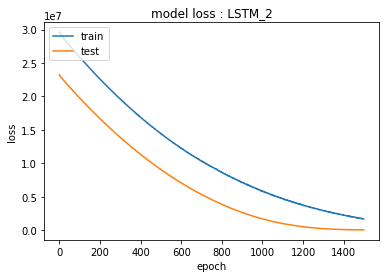

In [31]:
plot_accuracy(history)

In [32]:
data = X_train[-5:]
print(model.predict([data]))
print(Y_train[-5:])


[[3737.2786]
 [3674.809 ]
 [3729.845 ]
 [3749.332 ]
 [3734.5693]]
[[3788.]
 [3675.]
 [3768.]
 [3732.]
 [4016.]]


In [33]:
data[0]

array([[ 4.06759657e-01,  4.13090129e-01,  4.13733906e-01,
         3.84334764e-01,  8.08261803e-03,  2.03326180e-03],
       [ 4.47424893e-01,  4.14270386e-01,  4.55150215e-01,
         4.10085837e-01,  7.03648069e-03,  1.07296137e-03],
       [ 4.05364807e-01,  4.10944206e-01,  4.31330472e-01,
         3.97854077e-01,  5.41523605e-03, -1.00858369e-03],
       [ 4.17060086e-01,  4.20386266e-01,  4.24785408e-01,
         4.03004292e-01,  3.93776824e-03,  3.10085837e-04],
       [ 3.96244635e-01,  3.80901288e-01,  3.96244635e-01,
         3.71781116e-01,  3.88090129e-03, -5.35407725e-04]])

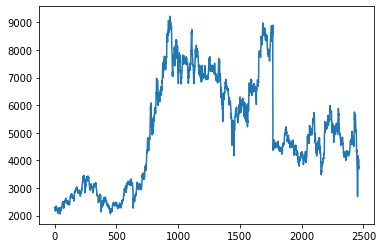

In [34]:
plt.plot(Y_train)

In [35]:
model.save('softbank.h5')

In [36]:
from keras.models import load_model
m = load_model('softbank.h5')


In [37]:
m.predict([data])

array([[3737.2786],
       [3674.809 ],
       [3729.845 ],
       [3749.332 ],
       [3734.5693]], dtype=float32)

In [38]:
m.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________
